# install gensim

In [6]:
!pip install gensim

  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)


In [3]:
!pip install nltk

In [20]:
!pip3 install --upgrade numpy

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import gensim
from gensim import corpora
import numpy as np
import csv
import os

C:\Users\lin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def get_text(filepath):
    doc = ""
    with open(filepath, 'r') as f:
        for line in f.readlines():
            doc += line
    return doc

stop = set(stopwords.words('english'))
single_char = set(string.ascii_lowercase)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean_old(doc):
    
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop]) # lowercase and remove stop word
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split()) #lemmatization
    return normalized

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop]) # lowercase and remove stop word
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude) #remove punc
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split()) #lemmatization
    removed_single = " ".join(i for i in normalized.split() if i not in single_char) #remove single alpha
    lis = removed_single.split()
    return list(filter(lambda x :not x.isdigit(), lis))

In [4]:
"\a" in exclude

False

In [5]:
def get_cik(filename):
    c = 0
    for i in range(len(filename)):
        if (filename[i] == '_'):
            c += 1
        if (c == 5):
            return int(filename[i+1:i+11])
    
get_cik("20000103_10-K_edgar_data_12040_0000914317-00-000002.txt-item1.txt")

914317

# train

In [3]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [5]:
lemma = WordNetLemmatizer()

In [87]:
lis = ['1010', 'a' ,' a0']
a = 
list(a)

['a', ' a0']

# get dictionary

In [7]:
root = "C:\\Users\\lin\\Box\\Yijun-Jingya\\10-K match content\\"

In [8]:


comp_set = set()
with open(root + "00-21 company list.csv", 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if (row[12] != '' and row[12] != 'cik'):
            comp_set.add(int(row[12]))

In [9]:
len(comp_set)

4443

In [10]:
int('0000914317')

914317

In [11]:
def get_cik(filename):
    c = 0
    for i in range(len(filename)):
        if (filename[i] == '_'):
            c += 1
        if (c == 5):
            return int(filename[i+1:i+11])
    
get_cik("20000103_10-K_edgar_data_12040_0000914317-00-000002.txt-item1.txt")

914317

In [12]:
dic = corpora.Dictionary.load_from_text(root + 'dictionary21years')

In [61]:
years = 2000
yeare = 2021

dic = corpora.Dictionary()
for year in range(years, yeare+1):
    text_dic = {}
    # extract text for one year
    for item in (['item1', 'item1A']):
        for qtr in (['QTR1','QTR2','QTR3','QTR4']):
            pre = root + "\\" + str(year) + "\\" + item + "\\" + qtr + "\\"
            filelist = os.listdir(pre)
            for file in filelist:
                cik = get_cik(file)
                if (cik in comp_set):
                    if (cik not in text_dic.keys()):
                        text_dic[cik] = ""
                    text_dic[cik] += get_text(pre+file)
    
    doc_clean = []
    for cik, text in text_dic.items():
        doc_clean.append(clean(text).split())
    dic.add_documents(doc_clean)
    

In [13]:
len(dic)

161867

In [25]:
dic.filter_extremes(no_below=5, no_above=0.9)
len(dic)

46382

In [16]:
dic.save_as_text(root+"dic-no_belo")

# run model

In [26]:
Lda = gensim.models.ldamodel.LdaModel

In [57]:
years = 2000
yeare = 2021
num_topic = 50
lda = Lda(id2word=dic, num_topics=num_topic)
perplexity = []
for year in range(years, yeare+1):
    text_dic = {}
    # extract text for one year
    for item in (['item1', 'item1A']):
        for qtr in (['QTR1','QTR2','QTR3','QTR4']):
            pre = root + "\\" + str(year) + "\\" + item + "\\" + qtr + "\\"
            filelist = os.listdir(pre)
            for file in filelist:
                cik = get_cik(file)
                if (cik in comp_set):
                    if (cik not in text_dic.keys()):
                        text_dic[cik] = ""
                    text_dic[cik] += get_text(pre+file)
    
    doc_clean = []
    for cik, text in text_dic.items():
        doc_clean.append(clean(text))
    doc_term_matrix = [dic.doc2bow(doc) for doc in doc_clean]
    lda.update(doc_term_matrix, passes=20)
    perplexity.append(lda.log_perplexity(doc_term_matrix))
    
    print(str(year) + " completed")

2000 completed
2001 completed
2002 completed
2003 completed
2004 completed
2005 completed
2006 completed
2007 completed
2008 completed
2009 completed
2010 completed
2011 completed
2012 completed
2013 completed
2014 completed
2015 completed
2016 completed
2017 completed
2018 completed
2019 completed
2020 completed
2021 completed


In [58]:
topics = lda.show_topics()

In [59]:
from gensim.test.utils import datapath
tmp_path = datapath(root+"models\\"+"model-"+str(num_topic))
lda.save(tmp_path)

In [24]:
#20: -204.82381584048713
#50: -246.23196211337986
#80: -292.6027305910056
#100:
#110:-345.1356522041037
#150:-412.9358242525766


NameError: name 'perplexity' is not defined

# load

In [50]:
tmp_path = datapath(root+"models\\"+"model-100")
# tmp_path = datapath(root+"models\\model-80")
print(tmp_path)
lda = Lda.load(tmp_path, mmap='r')


C:\Users\lin\Box\Yijun-Jingya\10-K match content\models\model-100


In [60]:
lda.show_topics(-1)[:10]

[(0,
  '0.028*"manufacturing" + 0.020*"design" + 0.018*"component" + 0.016*"technology" + 0.016*"supply" + 0.013*"supplier" + 0.011*"manufacturer" + 0.011*"order" + 0.011*"inventory" + 0.011*"demand"'),
 (1,
  '0.439*"dental" + 0.165*"consumable" + 0.151*"mercury" + 0.117*"philippine" + 0.000*"pursing" + 0.000*"otte" + 0.000*"mp34" + 0.000*"shirley" + 0.000*"mondry" + 0.000*"wwwmicroncom"'),
 (2,
  '0.000*"pursing" + 0.000*"roderic" + 0.000*"durcan" + 0.000*"hawkins" + 0.000*"marketingeconomics" + 0.000*"mche" + 0.000*"megapixel" + 0.000*"mondry" + 0.000*"mp34" + 0.000*"otte"'),
 (3,
  '0.539*"mineral" + 0.133*"coal" + 0.069*"drill" + 0.054*"walking" + 0.000*"marketingeconomics" + 0.000*"mondry" + 0.000*"megapixel" + 0.000*"otte" + 0.000*"roderic" + 0.000*"mche"'),
 (4,
  '0.730*"optical" + 0.096*"tension" + 0.038*"diagnose" + 0.022*"electron" + 0.020*"geospatial" + 0.008*"important" + 0.003*"imagery" + 0.003*"corning" + 0.000*"otte" + 0.000*"shirley"'),
 (5,
  '0.186*"fiscal" + 0.044*

In [53]:
years = 2000
yeare = 2021
topic_dic = {}


for year in range(years, yeare+1):
    topic_dic[year] = {}
    text_dic = {}
    # extract text for one year
    for item in (['item1', 'item1A']):
        for qtr in (['QTR1','QTR2','QTR3','QTR4']):
            pre = root + str(year) + "\\" + item + "\\" + qtr + "\\"
            filelist = os.listdir(pre)
            for file in filelist:
                cik = get_cik(file)
                if (cik in comp_set):
                    if (cik not in text_dic.keys()):
                        text_dic[cik] = ""
                    text_dic[cik] += get_text(pre+file)
    

    for cik, text in text_dic.items():
        doc_matrix = dic.doc2bow(text.split())
        topic_dic[year][cik] = lda.get_document_topics(bow=doc_matrix, minimum_probability=0)
    print(str(year) + " completed")

2000 completed
2001 completed
2002 completed
2003 completed
2004 completed
2005 completed
2006 completed
2007 completed
2008 completed
2009 completed
2010 completed
2011 completed
2012 completed
2013 completed
2014 completed
2015 completed
2016 completed
2017 completed
2018 completed
2019 completed
2020 completed
2021 completed


In [54]:
topics = lda.print_topics(num_topics=-1)
num_topic = len(topics)
print(num_topic)
with open(root+'result\\word_distribution-' + str(num_topic) + '.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    # header = []
    # i = 0
    # for topic in topics:
    #   header.append("topic"+str(i+1)+"word")
    for topic in topics:
        oneline = []
        oneline2 = []
        oneline.append("topic"+str(topic[0]+1)+"_word")
        oneline2.append("topic"+str(topic[0]+1)+"_distribution")
        content = topic[1].split('+')
        for oneword in content:
            ratio, word = oneword.split('*')
            word = word.replace('"', '')
            oneline.append(word)
            oneline2.append(ratio)
        writer.writerow(oneline)
        writer.writerow(oneline2)

100


In [55]:
cols = {}
val = ['gvkey', 'fyear', 'tic', 'cusip', 'conm', 'cik', 'naics', 'sic']


with open(root + "00-21 company list.csv", 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        if (row['cik'] == ''):
            continue
        cik = int(row['cik'])
        year = int(row['fyear'])
        newRow = {}
        for k in val:
            newRow[k] = row[k]
        if cik not in cols.keys():
            cols[cik] = newRow


In [56]:
import csv

with open(root+ 'result\\topic_disctribution'+ str(num_topic) + '.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=val + [("topic"+str(i+1)) for i in range(num_topic)])
    writer.writeheader()
    for year in range(2000, 2022):
        for cik, l in topic_dic[year].items():
            oneline = {}
            oneline.update(cols[cik])
            oneline['fyear'] = year
            for topic, ratio in l:
                oneline["topic"+str(topic+1)] = ratio

            writer.writerow(oneline)

In [144]:
for year in range(2000,2022):
    if 87050 in topic_dic[year].keys():
        print(year)

2000


In [78]:
dic.doc2idx(['11229'])

[-1]

In [145]:
tmp_path = datapath(root+"models\\"+"model-" + str(20))
# tmp_path = datapath(root+"models\\model-80")
print(tmp_path)
lda = Lda.load(tmp_path, mmap='r')

C:\Users\lin\Box\Yijun-Jingya\10-K match content\models\model-20


## topic model for 2530sample.csv

In [6]:
folder="C:\\Users\\lin\\Box\\Yijun-Jingya\\Startup sample\\"

In [57]:
data = []
with open(folder+"2530sample.csv", 'r',encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        data.append(row)

In [58]:
len(data)

2530

In [94]:
dic = corpora.Dictionary()
doc_clean = []
for row in data:
    doc_clean.append(clean(row['a_description']))
dic.add_documents(doc_clean)


In [95]:
print(len(dic))
dic.filter_extremes(no_below=2, no_above=0.9)
dic.filter_tokens(bad_ids=[dic.token2id['also'], dic.token2id['inc']])
print(len(dic))
Lda = gensim.models.ldamodel.LdaModel
doc_term_matrix = [dic.doc2bow(doc) for doc in doc_clean]

10106
4634


In [86]:
num_topic = 10
lda = Lda(corpus=doc_term_matrix, iterations=100, id2word=dic, num_topics=num_topic)
print(lda.log_perplexity(doc_term_matrix))

-7.075697486053889


In [71]:
num_topic = 15
lda = Lda(id2word=dic, num_topics=num_topic)
lda.update(doc_term_matrix, passes=20)
print(lda.log_perplexity(doc_term_matrix))

-6.813486178108031


In [91]:
from gensim.test.utils import datapath
tmp_path = datapath(folder+"model\\"+"model-"+str(num_topic))
lda.save(tmp_path)

In [75]:
num_topic = 20
lda = Lda(id2word=dic, num_topics=num_topic)
lda.update(doc_term_matrix, passes=20)
print(lda.log_perplexity(doc_term_matrix))

-6.852714428905515


In [87]:
topics = lda.print_topics(num_topics=-1)
num_topic = len(topics)
print(num_topic)
with open(folder+'word_distribution-' + str(num_topic) + '.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for topic in topics:
        oneline = []
        oneline2 = []
        oneline.append("topic"+str(topic[0]+1)+"_word")
        oneline2.append("topic"+str(topic[0]+1)+"_distribution")
        content = topic[1].split('+')
        for oneword in content:
            ratio, word = oneword.split('*')
            word = word.replace('"', '')
            oneline.append(word)
            oneline2.append(ratio)
        writer.writerow(oneline)
        writer.writerow(oneline2)

10


In [88]:
with open(folder+ 'topic_disctribution'+ str(num_topic) + '.csv', 'w',encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(data[0].keys()) + [("topic"+str(i+1)) for i in range(num_topic)])
    writer.writeheader()
    c = 0
    
    for row in data:
        onedoc = clean(row['a_description'])
        onemat = dic.doc2bow(onedoc)
        lis = lda.get_document_topics(bow=onemat, minimum_probability=0)
        for topic, prob in lis:
            row["topic"+str(topic+1)] = prob
        writer.writerow(row)

In [63]:
c

2530

In [82]:
perplexity = []

for num_topic in range(5, 26):
    print("currently training "+str(num_topic))
    lda = Lda(corpus=doc_term_matrix, iterations=100, id2word=dic, num_topics=num_topic)
    perp = lda.log_perplexity(doc_term_matrix)
    perplexity.append(perp)


currently training 5
currently training 6
currently training 7
currently training 8
currently training 9
currently training 10
currently training 11
currently training 12
currently training 13
currently training 14
currently training 15
currently training 16
currently training 17
currently training 18
currently training 19
currently training 20
currently training 21
currently training 22
currently training 23
currently training 24
currently training 25


In [89]:
front = []
for num_topic in range(2, 5):
    print("currently training "+str(num_topic))
    lda = Lda(corpus=doc_term_matrix, iterations=100, id2word=dic, num_topics=num_topic)
    perp = lda.log_perplexity(doc_term_matrix)
    front.append(perp)

currently training 2
currently training 3
currently training 4


<function matplotlib.pyplot.show(close=None, block=None)>

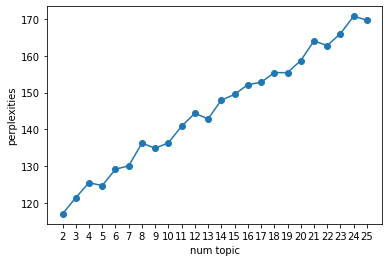

In [90]:
import matplotlib.pyplot as plt
plt.plot(range(2,26), np.exp2(-np.array(front+perplexity)), 'o-')
plt.xticks(range(2,26))
plt.xlabel('num topic')
plt.ylabel('perplexities')
plt.show

In [85]:
len(doc_term_matrix)

2530

## companies

In [6]:
import pandas as pd
from gensim.test.utils import datapath
Lda = gensim.models.ldamodel.LdaModel

In [7]:
folder="C:\\Users\\lin\\Box\\Yijun-Jingya\\Startup sample\\"

In [8]:
sampledata = []
with open(folder+"2530sample.csv", 'r',encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sampledata.append(row)

In [17]:
df = pd.read_stata(folder+'Company.dta',columns=['companyname', 'description'])     

In [18]:
data = df.values

In [10]:
phrases = ["real estate", "3D print", "artificial intelligence", "machine learning", "information technology", "information system"]

In [11]:
def keepPhrase(doc, phrases):
    doc = doc.lower()
    for ph in phrases:
        ph = ph.lower()
        repl = ph.replace(" ", "\a")
        doc = doc.replace(ph, repl)
    return doc
    
keepPhrase("dsad real estate 3D print asdasd", phrases)

'dsad real\x07estate 3d\x07print asdasd'

In [30]:
dic = corpora.Dictionary()
doc_clean = []
for row in data:
    doc_clean.append(clean(keepPhrase(row[1], phrases)))
dic.add_documents(doc_clean)

In [49]:
toremoved = ['inc','also','enabling', 'include', 'intended']
badids = []
for w in toremoved:
    try:
        badids.append(dic.token2id[w])
    except:
        pass
        
badids

[155, 92, 45]

In [50]:
print(len(dic))
dic.filter_extremes(no_below=5, no_above=0.9)
dic.filter_tokens(bad_ids=badids)
print(len(dic))

doc_term_matrix = [dic.doc2bow(doc) for doc in doc_clean]

33471
33468


In [36]:
dic.token2id['3d']

958

In [64]:
for num_topic in [15,20,25]:
    lda = Lda(corpus=doc_term_matrix, iterations=100, id2word=dic, num_topics=num_topic)
    print(lda.log_perplexity(doc_term_matrix))
    topics = lda.print_topics(num_topics=-1)
    num_topic = len(topics)
    print(num_topic)
    
    tmp_path = datapath(folder+"model\\"+"model-phrase-"+str(num_topic))
    lda.save(tmp_path)
    with open(folder+'word_distribution-company.dta-' + str(num_topic) + '.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        for topic in topics:
            oneline = []
            oneline2 = []
            oneline.append("topic"+str(topic[0]+1)+"_word")
            oneline2.append("topic"+str(topic[0]+1)+"_distribution")
            content = topic[1].split('+')
            for oneword in content:
                ratio, word = oneword.split('*')
                word = word.replace('"', '')
                oneline.append(word)
                oneline2.append(ratio)
            writer.writerow(oneline)
            writer.writerow(oneline2)
            
    with open(folder+ 'topic_disctribution-company.dta-'+ str(num_topic) + '.csv', 'w',encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['companyname'] + [("topic"+str(i+1)) for i in range(num_topic)])
        writer.writeheader()
        c = 0

        for row in data:
            oneline = {}
            oneline['companyname'] = row[0]
            onedoc = clean(keepPhrase(row[1], phrases))
            onemat = dic.doc2bow(onedoc)
            lis = lda.get_document_topics(bow=onemat, minimum_probability=0)
            for topic, prob in lis:
                oneline["topic"+str(topic+1)] = prob
            writer.writerow(oneline)

-8.94411369828167
15
-9.402660178934346
20
-9.81473472112071
25


In [57]:
num_topic = 25


-9.82768388023049


In [53]:
num_topic = 20
lda = Lda(corpus=doc_term_matrix, iterations=100, id2word=dic, num_topics=num_topic)
print(lda.log_perplexity(doc_term_matrix))

-9.392690481612858


In [58]:
topics = lda.print_topics(num_topics=-1)
num_topic = len(topics)
print(num_topic)
with open(folder+'word_distribution-company.dta-' + str(num_topic) + '.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for topic in topics:
        oneline = []
        oneline2 = []
        oneline.append("topic"+str(topic[0]+1)+"_word")
        oneline2.append("topic"+str(topic[0]+1)+"_distribution")
        content = topic[1].split('+')
        for oneword in content:
            ratio, word = oneword.split('*')
            word = word.replace('"', '')
            oneline.append(word)
            oneline2.append(ratio)
        writer.writerow(oneline)
        writer.writerow(oneline2)

25


In [44]:
perplexity = []

for num_topic in range(5, 26):
    print("currently training "+str(num_topic))
    lda = Lda(corpus=doc_term_matrix, iterations=100, id2word=dic, num_topics=num_topic)
    perp = lda.log_perplexity(doc_term_matrix)
    perplexity.append(perp)

currently training 5
currently training 6
currently training 7
currently training 8
currently training 9
currently training 10
currently training 11
currently training 12
currently training 13
currently training 14
currently training 15
currently training 16
currently training 17
currently training 18
currently training 19
currently training 20
currently training 21
currently training 22
currently training 23
currently training 24
currently training 25


<function matplotlib.pyplot.show(close=None, block=None)>

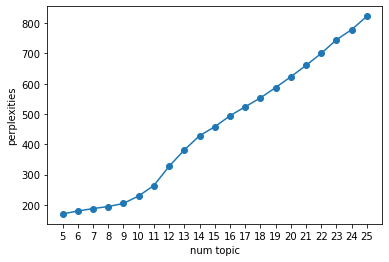

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(5,26), np.exp2(-np.array(perplexity)), 'o-')
plt.xticks(range(5,26))
plt.xlabel('num topic')
plt.ylabel('perplexities')
plt.show

In [18]:
num_topic = 20
tmp_path = datapath(folder+"model\\"+"model-phrase-"+str(num_topic))
print(tmp_path)
lda = Lda.load(tmp_path, mmap='r')


C:\Users\lin\Box\Yijun-Jingya\Startup sample\model\model-phrase-20


In [19]:
topics = lda.print_topics(num_topics=-1)
num_topic = len(topics)
print(num_topic)
with open(folder+'word_distribution-company.dta-' + str(num_topic) + '.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for topic in topics:
        oneline = []
        oneline2 = []
        oneline.append("topic"+str(topic[0]+1)+"_word")
        oneline2.append("topic"+str(topic[0]+1)+"_distribution")
        content = topic[1].split('+')
        for oneword in content:
            ratio, word = oneword.split('*')
            word = word.replace('"', '')
            oneline.append(word)
            oneline2.append(ratio)
        writer.writerow(oneline)
        writer.writerow(oneline2)

20


In [20]:

with open(folder+ 'topic_disctribution-company.dta-'+ str(num_topic) + '.csv', 'w',encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=list(sampledata[0].keys()) + [("topic"+str(i+1)) for i in range(num_topic)])
        writer.writeheader()
        c = 0

        for row in sampledata:
            onedoc = clean(keepPhrase(row["a_description"], phrases))
            onemat = dic.doc2bow(onedoc)
            lis = lda.get_document_topics(bow=onemat, minimum_probability=0)
            for topic, prob in lis:
                row["topic"+str(topic+1)] = prob
            writer.writerow(row)

In [13]:
dic = lda.__dict__['id2word']

In [30]:
len(dic)

33468

# Visualization

In [10]:
num_topic = 15
tmp_path = datapath(folder+"model\\"+"model-phrase-"+str(num_topic))
lda = Lda.load(tmp_path, mmap='r')
print(tmp_path)

C:\Users\lin\Box\Yijun-Jingya\Startup sample\model\model-phrase-15


In [35]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
# reference: https://amueller.github.io/word_cloud/auto_examples/simple.html
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  prefer_horizontal=0.7)

topics = lda.show_topics(formatted=False, num_topics=-1)

for topic in topics:
    num = topic[0]
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words)
    cloud.to_file(folder+"topic"+str(num)+".png")

# fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
# print(topic_words)
# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [36]:
len(topics)

15